<a href="https://colab.research.google.com/github/dogukartal/IBM_AI_Labs/blob/main/Deep%20Learning%20with%20Keras%20and%20Tensorflow/Transformers%20in%20Keras/Building_Advanced_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tensorflow pyarrow
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install requests

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

In [2]:
# Create a synthetic stock price dataset
np.random.seed(42)
data_length = 2000  # Adjust data length as needed
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

# Create a DataFrame and save as 'stock_prices.csv'
data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)

In [3]:
# Load the dataset
data = pd.read_csv('stock_prices.csv')
data = data[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Prepare the data for training
def create_dataset(data, time_step=1):
    X, Y = [], []

    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


In [4]:
class MultiHeadSelfAttention(Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim  # Total embedding dimension of the input
        self.num_heads = num_heads  # Number of attention heads
        self.projection_dim = embed_dim // num_heads  # Dimension of each attention head
        self.query_dense = Dense(embed_dim)  # Dense layer for projecting the input to query space
        self.key_dense = Dense(embed_dim)  # Dense layer for projecting the input to key space
        self.value_dense = Dense(embed_dim)  # Dense layer for projecting the input to value space
        self.combine_heads = Dense(embed_dim)  # Dense layer for combining the outputs from all heads

    def attention(self, query, key, value):
        # Computes the attention scores and the weighted sum of the values
        score = tf.matmul(query, key, transpose_b=True)  # Dot product between query and key vectors
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)  # Scaling factor (dimension of key)
        scaled_score = score / tf.math.sqrt(dim_key)  # Scale the scores for numerical stability
        weights = tf.nn.softmax(scaled_score, axis=-1)  # Apply softmax to get attention weights
        output = tf.matmul(weights, value)  # Weighted sum of the value vectors
        return output, weights

    def split_heads(self, x, batch_size):
        # Splits the input into multiple heads for parallel attention computation
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # Rearranges dimensions to [batch_size, num_heads, seq_len, projection_dim]

    def call(self, inputs):
        # Applies the self-attention mechanism and combines the heads
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # Project input to query space
        key = self.key_dense(inputs)  # Project input to key space
        value = self.value_dense(inputs)  # Project input to value space
        query = self.split_heads(query, batch_size)  # Split query into multiple heads
        key = self.split_heads(key, batch_size)  # Split key into multiple heads
        value = self.split_heads(value, batch_size)  # Split value into multiple heads
        attention, _ = self.attention(query, key, value)  # Compute attention output
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # Rearrange back to original format
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))  # Combine all heads
        output = self.combine_heads(concat_attention)  # Final linear projection
        return output

In [7]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)  # Multi-head self-attention mechanism
        self.ffn = tf.keras.Sequential([  # Feed-forward network
            Dense(ff_dim, activation="relu"),  # First dense layer with ReLU activation
            Dense(embed_dim),  # Second dense layer projecting back to the embedding dimension
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)  # Layer normalization after self-attention
        self.layernorm2 = LayerNormalization(epsilon=1e-6)  # Layer normalization after feed-forward network
        self.dropout1 = Dropout(rate)  # Dropout layer for regularization after self-attention for preventing overfitting
        self.dropout2 = Dropout(rate)  # Dropout layer for regularization after feed-forward network for preventing overfitting

    def call(self, inputs, training):
        attn_output = self.att(inputs)  # Apply multi-head self-attention
        attn_output = self.dropout1(attn_output, training=training)  # Apply dropout during training
        out1 = self.layernorm1(inputs + attn_output)  # Add residual connection and normalize
        ffn_output = self.ffn(out1)  # Apply feed-forward network
        ffn_output = self.dropout2(ffn_output, training=training)  # Apply dropout during training
        return self.layernorm2(out1 + ffn_output)  # Add residual connection and normalize

In [8]:
class EncoderLayer(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)  # Multi-head self-attention mechanism
        self.ffn = tf.keras.Sequential([  # Feed-forward network
            Dense(ff_dim, activation="relu"),  # First dense layer with ReLU activation
            Dense(embed_dim),  # Second dense layer projecting back to the embedding dimension
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)  # Layer normalization after self-attention
        self.layernorm2 = LayerNormalization(epsilon=1e-6)  # Layer normalization after feed-forward network
        self.dropout1 = Dropout(rate)  # Dropout for regularization after self-attention
        self.dropout2 = Dropout(rate)  # Dropout for regularization after feed-forward network

    def call(self, inputs, training):
        attn_output = self.att(inputs)  # Compute the multi-head self-attention output
        attn_output = self.dropout1(attn_output, training=training)  # Apply dropout during training
        out1 = self.layernorm1(inputs + attn_output)  # Add residual connection and normalize
        ffn_output = self.ffn(out1)  # Pass through the feed-forward network
        ffn_output = self.dropout2(ffn_output, training=training)  # Apply dropout during training
        return self.layernorm2(out1 + ffn_output)  # Add residual connection and normalize


In [16]:
class TransformerEncoder(Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.num_layers = num_layers  # Number of encoder layers in the transformer
        self.embed_dim = embed_dim  # Embedding dimension for each input vector
        # Create a list of TransformerBlock layers for the encoder stack
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)  # Dropout layer for initial input regularization

    def call(self, inputs, training=False):
        x = inputs  # Initial input to the encoder
        for i in range(self.num_layers):
            # Pass the input through each encoder layer sequentially
            x = self.enc_layers[i](x, training=training)
        return x  # Final output after all encoder layers


In [37]:
X.shape[1], X.shape[2]

(100, 1)

In [17]:
# Define the parameters
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

# Define the Transformer Encoder
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)

# Build the model
input_shape = (X.shape[1], X.shape[2])
inputs = tf.keras.Input(shape=input_shape)

# Project the inputs to the embed_dim
x = tf.keras.layers.Dense(embed_dim)(inputs)
encoder_outputs = transformer_encoder(x)
flatten = tf.keras.layers.Flatten()(encoder_outputs)
outputs = tf.keras.layers.Dense(1)(flatten)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_150 (Dense)                    │ (None, 100, 128)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_5                │ (None, 100, 128)            │         793,088 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_151 (Dense)                    │ (None, 1)                   │          12,801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the model on the normalized syntetic stock price data
model.fit(X, Y, epochs=20, batch_size=32)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 257ms/step - loss: 11.6782
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1949
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1789
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1816
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1534
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1376
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1218
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1271
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1310
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1621
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1758
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0771
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0676
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0589
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0578
E

### Step 8: Evaluate and Make Predictions

Evaluate the model's performance and make predictions on the dataset.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


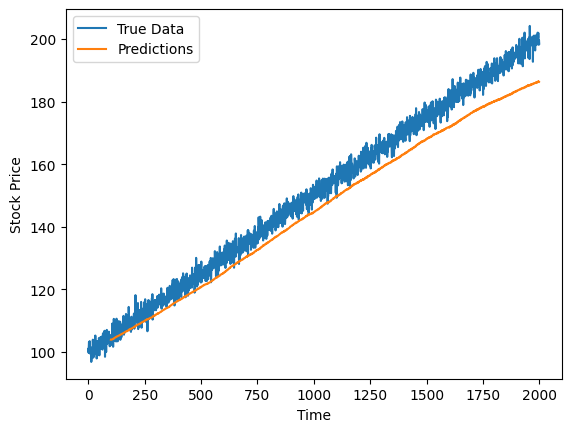

In [27]:
# Make predictions
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

# Plot the predictions
import matplotlib.pyplot as plt

plt.plot(synthetic_data, label='True Data')
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Adding Dropout Layer


In [30]:
from tensorflow.keras.layers import Dropout

# Add a dropout layer after the Flatten layer
flatten = tf.keras.layers.Flatten()(encoder_outputs)
dropout = Dropout(0.5)(flatten)
outputs = tf.keras.layers.Dense(1)(dropout)

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)

print(f'Test loss: {loss}')

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 249ms/step - loss: 5.0600
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8607
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3827
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1265
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0722
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0578
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0532
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0459
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0400
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0378
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0351
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0301
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0317
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0304
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0258
Ep

Loss decreased

## Experimenting with Different Batch Sizes

In [31]:
# Train the model with batch size 16
model.fit(X, Y, epochs=20, batch_size=16)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 16: {loss}')

# Train the model with batch size 64
model.fit(X, Y, epochs=20, batch_size=64)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 64: {loss}')

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0277
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0428
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0220
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0264
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0237
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0295
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0320
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0169
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0209
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0179
Epoch 11/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0099
Epoch 12/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0108
Epoch 13/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0129
Epoch 14/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0206
Epoch 15/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

##  Use a different activation function


In [32]:
# Change the activation function of the Dense layer to tanh
outputs = tf.keras.layers.Dense(1, activation='tanh')(flatten)

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with tanh activation: {loss}')

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 217ms/step - loss: 0.1354
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0101
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0038
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0047
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0021
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0022
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0017
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0021
Ep

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step


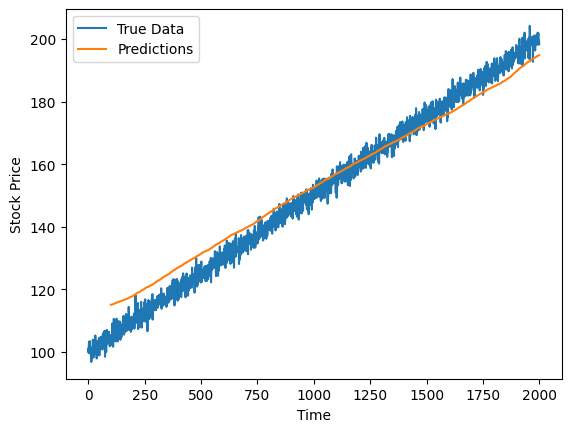

In [34]:
# Make predictions
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

# Plot the predictions
import matplotlib.pyplot as plt

plt.plot(synthetic_data, label='True Data')
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()